In [1]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

import numpy as np
from scipy.stats import norm, chi2
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Load the data from the provided file
file_path = 'PN_data.pkl'
data = pd.read_pickle(file_path)

N = data['N']
P = data['P']
P_err = data['P_err']

In [3]:
# import importlib
# importlib.reload(find_N90)

### Finding `N_90`

In [4]:
from find_N90 import plot_NP, goodness_of_fit

plot_filepath=False

def third_degree(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d 

# Replace 0 uncertainties with 0.00001 so as to 
# not produce errors in the least squares estimation
P_err[P_err == 0.0] = 0.00001

# ------------------
# should maybe use starting values
# ------------------
params, cov = curve_fit(third_degree, N, P, sigma=P_err, absolute_sigma=False)

a, b, c, d = params
a_err, b_err, c_err, d_err = np.sqrt(np.diag(cov))

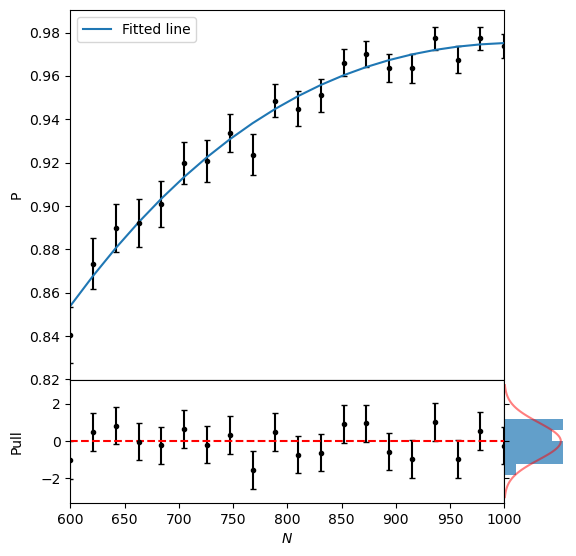

In [5]:
P_pred = third_degree(N, *params)

plot_NP(N, P, P_err, P_pred, filepath=plot_filepath)

Coverage and goodness of fit:

In [6]:
# ------------------
# Finding % that fitted line goes through uncertainties
# ------------------

pull = (P - P_pred)/P_err

n_intercepts = np.count_nonzero(np.abs(pull) < 1)
coverage = n_intercepts/len(pull)
print(f'Coverage: {coverage}')

# ------------------
# Goodness of fit test
# ------------------

Z, p_value = goodness_of_fit(pull)
print(f'p value: {p_value}, Z: {Z}')

Coverage: 0.85
p value: 0.7775259204134654, Z: 0.28254464271818935


#### Errors on params are way too big:

In [7]:
print(d, d_err)

-0.12023945530993402 0.5900617657617387


/Users/willknott/miniconda3/envs/pds/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


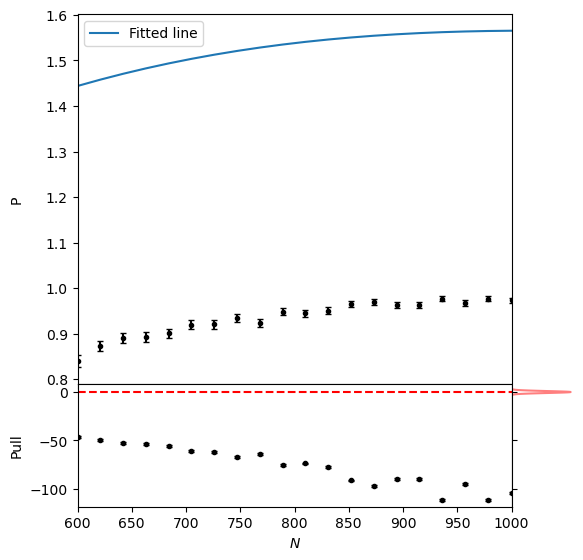

In [8]:
P_pred2 = third_degree(N, a, b, c, d=d+d_err)

plot_NP(N, P, P_err, P_pred2, filepath=plot_filepath)


### Finding N_90

In [9]:
from scipy.optimize import fsolve
import numpy as np

target_value = 0.9

# Define the cubic equation
def cubic_equation(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d - target_value

# Initial guess for x
initial_guess = 700

# Solve for x
N_90 = fsolve(cubic_equation, initial_guess, args=(a, b, c, d))[0]

print(N_90)

third_degree(N_90, *params)

677.263016062091


0.9000000000000001

Monte Carlo simulation by randomly sampling the coefficients within their uncertainties and solving the cubic equation for each set of coefficients to estimate the uncertainty. 

This doesnt work for now, since the errors are way too big

In [10]:
import numpy as np

# Number of simulations for Monte Carlo
num_simulations = 5

# Generate random samples for each coefficient within their uncertainties
a_samples = np.random.normal(a, a_err, num_simulations)
b_samples = np.random.normal(b, b_err, num_simulations)
c_samples = np.random.normal(c, c_err, num_simulations)
d_samples = np.random.normal(d, d_err, num_simulations)

In [11]:
# Solve the cubic equation for each set of sampled coefficients
x_solutions = np.array([fsolve(cubic_equation, initial_guess, args=(a_sample, b_sample, c_sample, d_sample))[0]
                        for a_sample, b_sample, c_sample, d_sample in zip(a_samples, b_samples, c_samples, d_samples)])

# Calculate the standard deviation of the solutions, which represents the uncertainty in x
x_uncertainty_monte_carlo = np.std(x_solutions)

print( x_uncertainty_monte_carlo, np.mean(x_solutions) )

458.9594003438345 600.0917584035117


/Users/willknott/miniconda3/envs/pds/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/willknott/miniconda3/envs/pds/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
